In [1]:
import os
import sys
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Unzip the file (old) - Don't run if already run extract.sh

In [ ]:
zipfiles = !ls | grep ".zip"

In [ ]:
# importing required modules
from zipfile import ZipFile

def pyunzip(file_name):
    # opening the zip file in READ mode
    with ZipFile(file_name, 'r') as zip:
        # printing all the contents of the zip file
        zip.printdir()

        # extracting all the files
        print('Extracting all the files now...')
        zip.extractall()
        print('Done!')

In [ ]:
dontuse = ['velodyne_points', 'image_00', 'image_01']
for zf in zipfiles:
    !unzip {zf}
    where = "{}/{}".format(zf[:10], zf[:-4])
    for du in dontuse:
        !rm -r {where+'/'+du}

In [ ]:
zipfiles[0][:-4]

# Examinating one of the extracted zip

In [ ]:
ls

In [3]:
roots = Path('.').iterdir()

roots=list(roots)

roots = [root for root in roots if root.is_dir() and "2011_" in root.name]

roots

[PosixPath('2011_09_29'),
 PosixPath('2011_09_30'),
 PosixPath('2011_09_26'),
 PosixPath('2011_09_28'),
 PosixPath('2011_10_03')]

In [11]:
root = np.random.choice(roots)
folder = np.random.choice([d for d in root.iterdir() if d.is_dir()]); folder

PosixPath('2011_09_29/2011_09_29_drive_0071_sync')

In [12]:
img02 = folder /'image_02'
img03 = folder /'image_03'

In [13]:
os.listdir(str(img02))

['timestamps.txt', 'data']

In [14]:
img02d = img02/'data'
img03d = img03/'data'

In [15]:
img02ds = sorted(os.listdir(str(img02d)))
img03ds = sorted(os.listdir(str(img03d)))

In [16]:
tuple(zip( img02ds[:5], img03ds[:5]))

(('0000000000.png', '0000000000.png'),
 ('0000000001.png', '0000000001.png'),
 ('0000000002.png', '0000000002.png'),
 ('0000000003.png', '0000000003.png'),
 ('0000000004.png', '0000000004.png'))

In [17]:
assert len( set(img02ds) - set(img03ds) ) == 0, set(img02ds) - set(img03ds)

In [18]:
with open(str(img02/'timestamps.txt')) as f:
    print(f.read()[:200])

2011-09-29 13:54:59.991359232
2011-09-29 13:55:00.095222784
2011-09-29 13:55:00.199085568
2011-09-29 13:55:00.302827776
2011-09-29 13:55:00.406692352
2011-09-29 13:55:00.510434048
2011-09-29 13:55:00.


In [19]:
with open(str(img03/'timestamps.txt')) as f:
    print(f.read()[:200])

2011-09-29 13:54:59.990872576
2011-09-29 13:55:00.094612992
2011-09-29 13:55:00.198486528
2011-09-29 13:55:00.302340864
2011-09-29 13:55:00.406079232
2011-09-29 13:55:00.509945344
2011-09-29 13:55:00.


In [20]:
list(root.iterdir())

[PosixPath('2011_09_29/calib_imu_to_velo.txt'),
 PosixPath('2011_09_29/2011_09_29_drive_0071_sync'),
 PosixPath('2011_09_29/2011_09_29_drive_0026_sync'),
 PosixPath('2011_09_29/2011_09_29_drive_0108_sync'),
 PosixPath('2011_09_29/2011_09_29_drive_0004_sync'),
 PosixPath('2011_09_29/calib_cam_to_cam.txt'),
 PosixPath('2011_09_29/calib_velo_to_cam.txt')]

In [21]:
cam = root/'calib_cam_to_cam.txt'

In [22]:
camret = {}
with cam.open('r') as f:
    for l in f:
        kv = l.rstrip().split(':')
        k, v = kv[0], kv[1]
        v= v.split(' ')[1:]
        camret[k] = v

In [23]:
camret.keys()

dict_keys(['calib_time', 'corner_dist', 'S_00', 'K_00', 'D_00', 'R_00', 'T_00', 'S_rect_00', 'R_rect_00', 'P_rect_00', 'S_01', 'K_01', 'D_01', 'R_01', 'T_01', 'S_rect_01', 'R_rect_01', 'P_rect_01', 'S_02', 'K_02', 'D_02', 'R_02', 'T_02', 'S_rect_02', 'R_rect_02', 'P_rect_02', 'S_03', 'K_03', 'D_03', 'R_03', 'T_03', 'S_rect_03', 'R_rect_03', 'P_rect_03'])

In [24]:
cam3para = np.array(tuple(float(e) for e in camret['P_rect_03'])).reshape(3,4)
cam2para = np.array(tuple(float(e) for e in camret['P_rect_02'])).reshape(3,4)

In [25]:
cam2para

array([[ 7.183351e+02,  0.000000e+00,  6.003891e+02,  4.450382e+01],
       [ 0.000000e+00,  7.183351e+02,  1.815122e+02, -5.951107e-01],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  2.616315e-03]])

In [26]:
cam3para

array([[ 7.183351e+02,  0.000000e+00,  6.003891e+02, -3.363147e+02],
       [ 0.000000e+00,  7.183351e+02,  1.815122e+02,  3.159867e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  5.323834e-03]])

# Visualization

In [27]:
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
HTML(ani.to_html5_video())

shape of a frame:  (374, 1238, 3)


RuntimeError: Requested MovieWriter (ffmpeg) not available

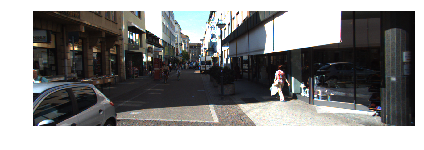

In [28]:
fig, ax = plt.subplots()

shape = plt.imread(str(img02d/img02ds[0])).shape
print('shape of a frame: ', shape)
im = ax.imshow(np.zeros(shape), animated=True)
ax.set_axis_off()
plt.tight_layout()

def frame(paths, root):
    for path in paths:
        yield plt.imread(str(root/path))

def animate(img):
    im.set_array(img)  # update the data
    return im

# Init only required for blitting to give a clean slate.
def init():
    im.set_array(np.zeros(shape))
    return im

ani = animation.FuncAnimation(fig, animate, frames=list(frame(img02ds, img02d)), interval=25)
HTML(ani.to_html5_video())

In [30]:
shape = np.array(shape[:2])
shape/ shape[0]

array([1.        , 3.31016043])

In [31]:
def gene_tri(imgs):
    return imgs[0:-2], imgs[1:-1], imgs[2:] 

In [32]:
tris = gene_tri(img02ds)

In [33]:
tris = tuple( zip(*tris) )

In [34]:
tris[0]

('0000000000.png', '0000000001.png', '0000000002.png')

In [35]:
def plot_tri(tri, path):
    f, axs=plt.subplots(3,1, figsize=(20, 6))
    for i, img in enumerate(tri):
        axs[i].imshow(plt.imread(str(path/img)))
        axs[i].set_axis_off()
    plt.show()

('0000000001.png', '0000000002.png', '0000000003.png')


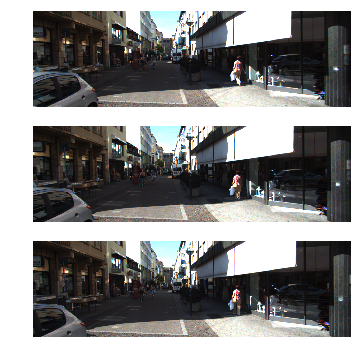

In [36]:
print(tris[1])
plot_tri(tris[1], img02d)

In [37]:
def stero_pair(pair, img):
    f, axs=plt.subplots(1,2, figsize=(24, 4))
    for i, loc in enumerate(pair):
        axs[i].imshow(plt.imread(str(loc/img)))
        axs[i].set_axis_off()
    plt.show()

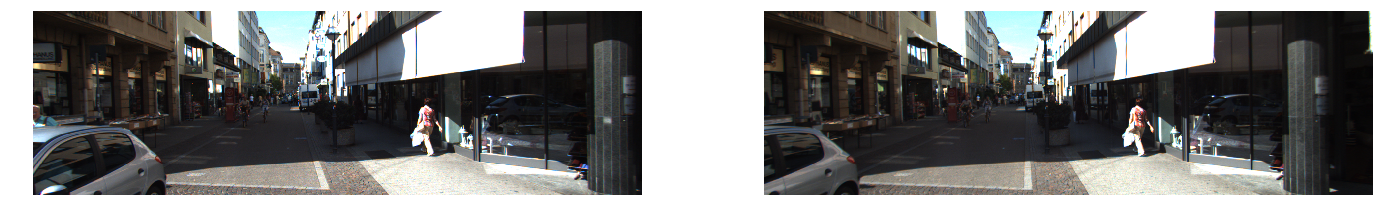

In [38]:
stero_pair((img02d, img03d), img02ds[0] )

# Convert the directory to csv

In [ ]:
from collections import namedtuple

In [ ]:
CAMPARA = namedtuple('campara',['fx','fy','cx','cy'])
def get_campara(date):
    cam = date/'calib_cam_to_cam.txt'
    camret = {}
    with cam.open('r') as f:
        for l in f:
            kv = l.rstrip().split(':')
            k, v = kv[0], kv[1]
            v= v.split(' ')[1:]
            camret[k] = v
    cam2para = np.array(tuple(float(e) for e in camret['P_rect_02'])).reshape(3,4)
    return CAMPARA(fx = cam2para[0,0], fy = cam2para[1,1], cx = cam2para[0,2], cy = cam2para[1,2])

In [ ]:
def gene_tri(imgs):
    return imgs[0:-2], imgs[1:-1], imgs[2:] 

In [ ]:
get_campara(root)

In [ ]:
roots = Path('.').iterdir()
roots=list(roots)
roots = [root for root in roots if root.is_dir() and '2011_' in root.name]
roots

In [ ]:
pwd()

In [ ]:
timgs0, timgs1, timgs2, paras = [], [], [], []
for root in roots:
    para = get_campara(root)
    folders = root.glob("*_sync")
    for folder in folders:
        img02 = folder /'image_02'/'data'
        img03 = folder /'image_03'/'data'
        
        for which in (img02, img03):
            imgs = sorted([str(img) for img in which.iterdir()])
            imgs0, imgs1, imgs2 = gene_tri(imgs)
            timgs0 += imgs0
            timgs1 += imgs1
            timgs2 += imgs2
            paras += [para]*len(imgs0)
paras = tuple(zip(*paras))

In [ ]:
train = pd.DataFrame(dict(t0=timgs0, t1=timgs1,t2=timgs2,
                          fx=paras[0],fy=paras[1],
                          cx=paras[2],cy=paras[3])
                    )
train.head()

In [ ]:
val = train.iloc[int(len(train)*0.9):]
train = train.iloc[:int(len(train)*0.9)]

In [ ]:
val.to_csv('validation.csv', index=False); train.to_csv('training.csv', index=False);